# Decoding: From Logits to the Speculative Decoding and Guard Rails

We've covered everything from loss to logits - and now we're going to dive in to how we select the next token in details, and all the options we can use to do it!

Breakout Room #1: Logits to Tokens
- Task 1: Dependencies
- Task 2: Generating Tokens!
  - 🏗️ Activity #1:
- Task 3: Data Preprocessing
  - ❓Question #1
- Task 4: Alternate Decoding Examples:
  - 👪❓ Discussion Question #1

Breakout Room #2: Speculative Decoding and Guard Rails
- Task 5: Speculative Decoding
  - ❓ Discussion Question #2
- Task 6: Guard Rails
  - 👪❓ Discussion Question #2

## Task 1: Dependencies

Today we'll be using a classic minamalist implementation of a decoder-only transformer model called `nanoGPT`, built by the one-and-only Andrej Karpathy - found [here](https://github.com/karpathy/nanoGPT/tree/master)!

It does require a few dependencies - though most are covered by the default Colab environment.

> NOTE: You will need to make sure you're in a GPU enabled environment for effective use of this notebook.

 ⚓  Base dependencies and Nano GPT setup. The key point here is that we're using a minimal implementation of a decoder-only transformer model by Andrej Karpathy to understand decoding mechanisms.**

In [1]:
!pip install -qU datasets tiktoken wandb tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!git clone https://github.com/karpathy/nanoGPT.git

Cloning into 'nanoGPT'...
remote: Enumerating objects: 686, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 686 (delta 0), reused 2 (delta 0), pack-reused 682 (from 1)
Receiving objects: 100% (686/686), 959.50 KiB | 35.54 MiB/s, done.
Resolving deltas: 100% (385/385), done.


In [3]:
%cd nanoGPT

/content/nanoGPT


## Task 2: Generating Tokens!

Let's just try to do some inference and see what happens before we dig in.

In [4]:
!python sample.py \
    --init_from=gpt2-xl \
    --start="What is the answer to life, the universe, and everything?" \
    --num_samples=1 --max_new_tokens=100

Overriding: init_from = gpt2-xl
Overriding: start = What is the answer to life, the universe, and everything?
Overriding: num_samples = 1
Overriding: max_new_tokens = 100
2024-12-10 20:56:42.358328: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 20:56:42.374400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 20:56:42.395555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 20:56:42.401901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cu

⚓

Key Concepts:

* Logits represent the "raw unnormalized scores" - technically the log of odds ratio for each token
* Logits are transformed into probabilities through softmax
* Temperature is applied before softmax by dividing logits by the temperature value

Temperature Effects:

* Temperature = 1.0: No modification to logits
* Temperature < 1.0: Makes distribution more peaked/concentrated (more deterministic)
* Temperature > 1.0: Makes distribution more uniform (more random/creative)

You'll notice that we pass *in* text - and we receive *back* text from our model.

##### 🏗️ Activity #1:

*Where* (in the architecture) exactly does NanoGPT go "from logits to predicted token"? Provide a screenshot from [this visualization](https://bbycroft.net/llm)!

⚓ The model goes from logits to predicted token at the final layer of the decoder, after the feed-forward network and before output. This is where temperature scaling and softmax occur to convert raw logits into probabilities.

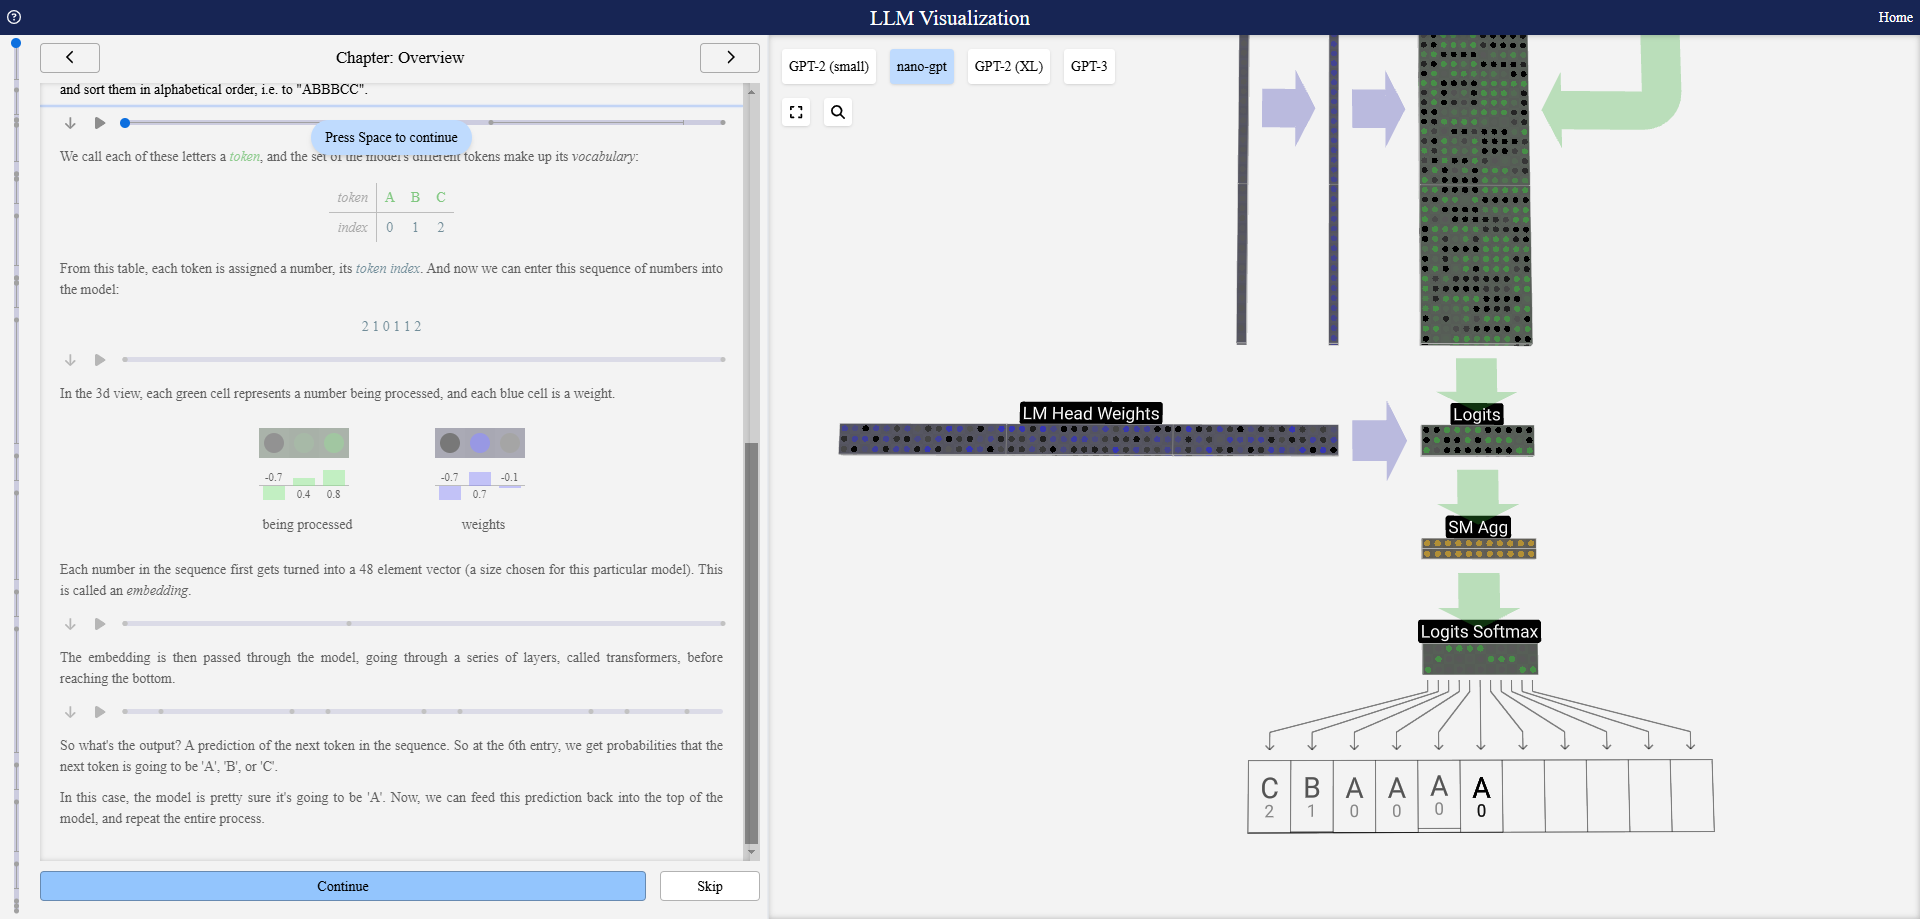

## Task 3: How Does the LLM Generate Tokens

So, we pas in text - and get text back - but how do we actually generate each token?

You might have heard the term "auto-regressive" or "causal" kicking around when reading about LLMs - and what those terms, in a simplified sense, mean is straightfoward enough:

- They take an input, and generate a single token
- They append that token to the input and repeat this process for as long as we want it to repeat (or use heuristics to determine when to stop, such as when we see a stop token)

Let's take a look at the function that does this in the `nanoGPT` repository.



```python
@torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx
```

### What is a Logit?!

Technically - a logit is a "raw unnormalized score".

However, we can think of them as scores for each token in our vocabulary. These scores aren't probabilities in and of themselves - but they can be easily converted to probabilities through the softmax function.

### What is Temperature Doing?!

While something like `top_k` makes intuitive sense - what in the heck is temperature doing here?

In order to understand - let's look at a few examples!

Starting with an easy `temperature = 1.0`.

> NOTE: We'll also define our softmax function!

In [5]:
def softmax(x):
    return(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())

In [6]:
import numpy as np

temperature = 1.0

logits = np.array([6, 2, 7, 0.1, -8, 9])

temp_scaled_logits = logits / temperature
print(f"Scaled Logits: {temp_scaled_logits}")

softmaxed_logits = softmax(temp_scaled_logits)
print(f"Softmax-ed Logits: {softmaxed_logits}")

Scaled Logits: [ 6.   2.   7.   0.1 -8.   9. ]
Softmax-ed Logits: [4.19729385e-02 7.68761185e-04 1.14094276e-01 1.14982549e-04
 3.49017038e-08 8.43049007e-01]


As you can see - our logits are not changed, and our softmax output has quite a bit of variety - from `e-08` to `e-1`, meaning that our index with the score `9` is most likely to be selected, but it's not absurdly likely.

Let's look at an example with a very low temperature next!

In [7]:
temperature = 0.1

logits = np.array([6, 2, 7, 0.1, -8, 9])

temp_scaled_logits = logits / temperature
print(f"Scaled Logits: {temp_scaled_logits}")

softmaxed_logits = softmax(temp_scaled_logits)
print(f"Softmax-ed Logits: {softmaxed_logits}")

Scaled Logits: [ 60.  20.  70.   1. -80.  90.]
Softmax-ed Logits: [9.35762295e-14 3.97544973e-31 2.06115362e-09 2.22736356e-39
 1.47889750e-74 9.99999998e-01]


As you can see - now that we changed our temperature to be very low - the index with score `9` is *vastly* more likely than any other option.

This is the idea that a low (<1) temperature value will scale our logits to be larger - resulting in a sharper probability distribution after softmax.

Let's look at a final example with a higher temperature.

In [8]:
temperature = 100

logits = np.array([6, 2, 7, 0.1, -8, 9])

temp_scaled_logits = logits / temperature
print(f"Scaled Logits: {temp_scaled_logits}")

softmaxed_logits = softmax(temp_scaled_logits)
print(f"Softmax-ed Logits: {softmaxed_logits}")

Scaled Logits: [ 0.06   0.02   0.07   0.001 -0.08   0.09 ]
Softmax-ed Logits: [0.17201758 0.16527268 0.17374639 0.16216214 0.1495449  0.1772563 ]


In [9]:
!python sample.py \
    --init_from=gpt2-xl \
    --start="What is the answer to life, the universe, and everything?" \
    --num_samples=1 --max_new_tokens=100 --temperature=100.0

Overriding: init_from = gpt2-xl
Overriding: start = What is the answer to life, the universe, and everything?
Overriding: num_samples = 1
Overriding: max_new_tokens = 100
Overriding: temperature = 100.0
2024-12-10 21:00:06.527991: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 21:00:06.544992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 21:00:06.565837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 21:00:06.572144: E external/local_xla/xla/stream_executor/cuda/cuda_bla

Now we can see that, while our index with score `9` is still the most likely - we can see that the probabilities are much closer together!

##### ❓ Question #1:

Why is the softmax operation so important for decoding?

⚓ Softmax is crucial for decoding because it:

1. Converts unbounded logits into valid probabilities (0-1 range)
2. Preserves relative rankings while making values comparable
3. Creates a proper probability distribution for sampling
4. Allows for temperature scaling to control randomness

## Task 4: Alternate Decoding Examples

Let's look at a few other methods we could use to go from our logits to some text!

We'll look at each component of the following script for each different method in detail as we go through them!

### Full Modified Generation Script

In [10]:
new_sample_script = r'''
"""
Sample from a trained model with various decoding strategies, including repetition penalty
"""
import os
import pickle
from contextlib import nullcontext
import torch
import torch.nn.functional as F
import tiktoken
from model import GPTConfig, GPT

# -----------------------------------------------------------------------------
init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out' # ignored if init_from is not 'resume'
start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 10 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
top_p = 0.0 # If set, use nucleus sampling
beam_width = 0 # If set, use beam search with this width
greedy = False # use greedy decoding
repetition_penalty = 1.0 # 1.0 means no penalty, > 1.0 discourages repetition, < 1.0 encourages repetition
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
exec(open('configurator.py').read()) # overrides from command line or config file
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
elif init_from.startswith('gpt2'):
    # init from a given GPT-2 model
    model = GPT.from_pretrained(init_from, dict(dropout=0.0))

model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

# look for the meta pickle in case it is available in the dataset folder
load_meta = False
if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
    meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
    load_meta = os.path.exists(meta_path)
if load_meta:
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
else:
    # ok let's assume gpt-2 encodings by default
    print("No meta.pkl found, assuming GPT-2 encodings...")
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)

# Top-P (nucleus) sampling
def top_p_sampling(logits, p):
    probs = F.softmax(logits, dim=-1)
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    sorted_indices_to_remove = cumulative_probs > p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
    probs = probs.masked_fill(indices_to_remove, 0.0)
    return torch.multinomial(probs, num_samples=1)

# Beam Search with Repetition Penalty
def beam_search(model, x, max_new_tokens, beam_width, repetition_penalty):
    beams = [(x, 0)]
    for _ in range(max_new_tokens):
        candidates = []
        for beam_idx, (sequence, log_prob) in enumerate(beams):
            if sequence.size(1) > model.config.block_size:
                idx_cond = sequence[:, -model.config.block_size:]
            else:
                idx_cond = sequence
            logits, _ = model(idx_cond)
            logits = logits[:, -1, :]

            # Apply repetition penalty
            if repetition_penalty != 1.0:
              # Get unique tokens in the generated sequence
              unique_tokens = torch.unique(x[0])

              # Create a mask for the tokens that have been used
              mask = torch.zeros_like(logits[0]).bool()
              mask[unique_tokens] = True

              # Apply the penalty only to the used tokens
              logits[0, mask] /= repetition_penalty

            probs = F.log_softmax(logits, dim=-1)
            top_probs, top_indices = probs.topk(beam_width)
            for prob, idx in zip(top_probs[0], top_indices[0]):
                new_sequence = torch.cat((sequence, idx.unsqueeze(0).unsqueeze(0)), dim=1)
                new_log_prob = log_prob + prob.item()
                candidates.append((new_sequence, new_log_prob))
        beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]
    return beams[0][0]

@torch.no_grad()
def generate(model, x, max_new_tokens, temperature=1.0, top_k=None, top_p=None, beam_width=None, repetition_penalty=1.0, greedy=False):
    print(f"Starting generation with max_new_tokens={max_new_tokens}")

    if beam_width != 0:
        print(f"Using beam search with width {beam_width}")
        return beam_search(model, x, max_new_tokens, beam_width, repetition_penalty)

    for i in range(max_new_tokens):
        if i % 100 == 0:
            print(f"Generated {i} tokens")

        if x.size(1) > model.config.block_size:
            idx_cond = x[:, -model.config.block_size:]
        else:
            idx_cond = x
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature

        # Apply repetition penalty
        if repetition_penalty != 1.0:
          # Get unique tokens in the generated sequence
          unique_tokens = torch.unique(x[0])

          # Create a mask for the tokens that have been used
          mask = torch.zeros_like(logits[0]).bool()
          mask[unique_tokens] = True

          # Apply the penalty only to the used tokens
          logits[0, mask] /= repetition_penalty

        if greedy:
            # Greedy decoding: select the token with the highest probability
            idx_next = torch.argmax(logits, dim=-1).unsqueeze(0)
        else:
            # Existing sampling methods
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            if top_p != 0.0:
                idx_next = top_p_sampling(logits, top_p)
            else:
                probs = F.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)

        x = torch.cat((x, idx_next), dim=1)

    print("Generation complete")
    return x

# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            print(f"Generating sample {k+1}/{num_samples}")
            y = generate(model, x, max_new_tokens, temperature=temperature, top_k=top_k, top_p=top_p,
                         beam_width=beam_width, repetition_penalty=repetition_penalty, greedy=greedy)
            print(decode(y[0].tolist()))
            print('---------------')
'''

with open('extended_sample.py', 'w') as f:
  f.write(new_sample_script)

### Vanilla Sample Generation

```python
@torch.no_grad()
def generate(model, x, max_new_tokens, temperature=1.0, top_k=None, top_p=None, beam_width=None, repetition_penalty=1.0, greedy=False):
    print(f"Starting generation with max_new_tokens={max_new_tokens}")
    
    if beam_width != 0:
        print(f"Using beam search with width {beam_width}")
        return beam_search(model, x, max_new_tokens, beam_width, repetition_penalty)

    for i in range(max_new_tokens):
        if i % 100 == 0:
            print(f"Generated {i} tokens")
        
        if x.size(1) > model.config.block_size:
            idx_cond = x[:, -model.config.block_size:]
        else:
            idx_cond = x
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature

        # Apply repetition penalty
        if repetition_penalty != 1.0:
          # Get unique tokens in the generated sequence
          unique_tokens = torch.unique(x[0])
          
          # Create a mask for the tokens that have been used
          mask = torch.zeros_like(logits[0]).bool()
          mask[unique_tokens] = True
          
          # Apply the penalty only to the used tokens
          logits[0, mask] /= repetition_penalty

        if greedy:
            # Greedy decoding: select the token with the highest probability
            idx_next = torch.argmax(logits, dim=-1).unsqueeze(0)
        else:
            # Existing sampling methods
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            if top_p != 0.0:
                idx_next = top_p_sampling(logits, top_p)
            else:
                probs = F.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)

        x = torch.cat((x, idx_next), dim=1)

    print("Generation complete")
    return x
```

As we can see - if we *don't* use a `top_p`, `top_k`, or `beam_width` - we simply sample the distribution as-in.

In [11]:
!python extended_sample.py \
    --init_from=gpt2-xl \
    --start="What is the answer to life, the universe, and everything?" \
    --num_samples=1 --max_new_tokens=100

Overriding: init_from = gpt2-xl
Overriding: start = What is the answer to life, the universe, and everything?
Overriding: num_samples = 1
Overriding: max_new_tokens = 100
2024-12-10 21:01:25.871480: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 21:01:25.888464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 21:01:25.909297: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 21:01:25.915608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cu

⚓ Major Decoding Strategies:

1. Greedy Decoding:


* Always selects highest probability token
* Fast but can be repetitive
* Deterministic output


2. Top-P (Nucleus) Sampling:


* Samples from tokens comprising top P% of probability mass
* Balances diversity and quality
* Adaptable to context


3. Beam Search:


* Maintains multiple candidate sequences
* Can be combined with repetition penalty
* More computationally intensive but potentially better quality

### Greedy Decoding

Greedy decoding is the simplest method for generating text from a language model. It works as follows:

1. **Prediction**: At each step, the model predicts the probability distribution for the next token.

2. **Selection**: The token with the highest probability is selected.

3. **Iteration**: This process is repeated until the desired length is reached or a stop condition is met.

Key characteristics of greedy decoding:

- **Deterministic**: Given the same input and model state, it always produces the same output.
- **Fast**: It's computationally efficient as it doesn't require sampling or complex calculations.
- **Lack of diversity**: It tends to generate repetitive and sometimes boring text, especially for longer sequences.

Let's check out the code!

```python
if greedy:
    # Greedy decoding: select the token with the highest probability
    idx_next = torch.argmax(logits, dim=-1).unsqueeze(0)
```

And see it in practice!

In [12]:
!python extended_sample.py \
    --init_from=gpt2-xl \
    --start="What is the answer to life, the universe, and everything?" \
    --num_samples=1 --max_new_tokens=100 --greedy=True

Overriding: init_from = gpt2-xl
Overriding: start = What is the answer to life, the universe, and everything?
Overriding: num_samples = 1
Overriding: max_new_tokens = 100
Overriding: greedy = True
2024-12-10 21:07:35.796738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 21:07:35.813730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 21:07:35.834576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 21:07:35.840949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1

That is a bit repetitive, is there way we can reduce this?

### Repetition Penalty

Repetition penalty is a technique used in text generation to reduce the likelihood of a model repeating the same words or phrases too frequently. It works by dynamically adjusting the probability of tokens that have already been generated.

Key aspects of repetition penalty:

1. **Penalization**: It decreases the probability of tokens that have appeared in the generated text.
2. **Adjustable strength**: The penalty can be tuned to control the trade-off between coherence and diversity.
3. **Applicability**: It can be applied alongside other decoding methods like greedy search, beam search, or sampling techniques.

The basic idea is to divide the logits (unnormalized prediction scores) of previously generated tokens by a penalty factor.

```python
if repetition_penalty != 1.0:
    # Consider only the last 1000 tokens (adjust as needed)
    window_size = 1000
    recent_tokens = x[0, -window_size:]
    
    # Get unique tokens in the recent sequence
    unique_tokens = torch.unique(recent_tokens)
    
    # Create a mask for the tokens that have been used recently
    mask = torch.zeros_like(logits[0]).bool()
    mask[unique_tokens] = True
    
    # Apply the penalty only to the recently used tokens
    logits[0, mask] /= repetition_penalty
```

Let's see it in practice!

In [13]:
!python extended_sample.py \
    --init_from=gpt2-xl \
    --start="What is the answer to life, the universe, and everything?" \
    --num_samples=1 --max_new_tokens=100 --greedy=True --repetition_penalty=1.8

Overriding: init_from = gpt2-xl
Overriding: start = What is the answer to life, the universe, and everything?
Overriding: num_samples = 1
Overriding: max_new_tokens = 100
Overriding: greedy = True
Overriding: repetition_penalty = 1.8
2024-12-10 21:12:15.594681: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 21:12:15.612191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 21:12:15.633662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 21:12:15.640222: E external/local_xla/xl

### Top-P (Nucleus) Sampling

Top-P sampling, also known as nucleus sampling, is a text generation technique that provides a balance between diversity and quality in the generated text. It works as follows:

1. **Sorting probabilities**: After the model produces the probability distribution for the next token, the probabilities are sorted in descending order.

2. **Cumulative sum**: A cumulative sum of these sorted probabilities is calculated.

3. **Probability mass selection**: A threshold p (typically between 0.9 and 1) is chosen. The smallest set of tokens whose cumulative probability exceeds p is selected.

4. **Sampling**: The next token is randomly sampled from this reduced set of tokens.

Key advantages of Top-P sampling:

- It adapts to the confidence of the model's predictions.
- It can produce more diverse outputs than methods like Top-K sampling, especially for less confident predictions.
- It helps avoid low-probability tokens while maintaining a dynamic vocabulary size.

```python
def top_p_sampling(logits, p):
    probs = F.softmax(logits, dim=-1)
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    sorted_indices_to_remove = cumulative_probs > p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
    probs = probs.masked_fill(indices_to_remove, 0.0)
    return torch.multinomial(probs, num_samples=1)
```

Let's see it in action!

In [14]:
!python extended_sample.py \
    --init_from=gpt2-xl \
    --start="What is the answer to life, the universe, and everything?" \
    --num_samples=1 --max_new_tokens=100 --top_p=0.95

Overriding: init_from = gpt2-xl
Overriding: start = What is the answer to life, the universe, and everything?
Overriding: num_samples = 1
Overriding: max_new_tokens = 100
Overriding: top_p = 0.95
2024-12-10 21:13:43.504182: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 21:13:43.521420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 21:13:43.542428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 21:13:43.548840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:14

Let's see this with a low temperature, and a high temperature and observe the difference!

Cold as ice:

In [15]:
!python extended_sample.py \
    --init_from=gpt2-xl \
    --start="What is the answer to life, the universe, and everything?" \
    --num_samples=1 --max_new_tokens=100 --top_p=0.95 --temperature=0.1

Overriding: init_from = gpt2-xl
Overriding: start = What is the answer to life, the universe, and everything?
Overriding: num_samples = 1
Overriding: max_new_tokens = 100
Overriding: top_p = 0.95
Overriding: temperature = 0.1
2024-12-10 21:14:33.364827: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 21:14:33.381843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 21:14:33.402699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 21:14:33.409043: E external/local_xla/xla/stream

Burning hot:

In [16]:
!python extended_sample.py \
    --init_from=gpt2-xl \
    --start="What is the answer to life, the universe, and everything?" \
    --num_samples=1 --max_new_tokens=100 --top_p=0.05 --temperature=100.0

Overriding: init_from = gpt2-xl
Overriding: start = What is the answer to life, the universe, and everything?
Overriding: num_samples = 1
Overriding: max_new_tokens = 100
Overriding: top_p = 0.05
Overriding: temperature = 100.0
2024-12-10 21:15:25.346757: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 21:15:25.363113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 21:15:25.384080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 21:15:25.390324: E external/local_xla/xla/stre

### Beam Search

Beam search is a heuristic search algorithm commonly used in natural language processing for text generation tasks. It's an extension of greedy decoding that explores multiple possible sequences simultaneously.

Key concepts:

1. **Beam width**: The number of sequences to keep track of at each step.
2. **Expanding**: At each step, generate all possible next tokens for each sequence in the beam.
3. **Pruning**: Keep only the top-k sequences (where k is the beam width) based on their cumulative probability scores.

Algorithm overview:

1. Start with an initial sequence (usually a start token).
2. Generate the next token probabilities for each sequence in the beam.
3. Create new candidate sequences by appending each possible next token.
4. Score each candidate sequence based on its cumulative log probability.
5. Select the top-k sequences to form the new beam.
6. Repeat steps 2-5 until the desired length is reached or a stop condition is met.

In [17]:
!python extended_sample.py \
    --init_from=gpt2-xl \
    --start="What is the answer to life, the universe, and everything?" \
    --num_samples=1 --max_new_tokens=50 --beam_width=16 --repetition_penalty=1.8 --temperature=1.4

Overriding: init_from = gpt2-xl
Overriding: start = What is the answer to life, the universe, and everything?
Overriding: num_samples = 1
Overriding: max_new_tokens = 50
Overriding: beam_width = 16
Overriding: repetition_penalty = 1.8
Overriding: temperature = 1.4
2024-12-10 21:16:18.541193: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 21:16:18.558102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 21:16:18.579164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 21:16:18.

In [18]:
!python extended_sample.py \
    --init_from=gpt2-xl \
    --start="Why is the sky blue?" \
    --num_samples=1 --max_new_tokens=50 --beam_width=16 --repetition_penalty=1.8 --temperature=1.4

Overriding: init_from = gpt2-xl
Overriding: start = Why is the sky blue?
Overriding: num_samples = 1
Overriding: max_new_tokens = 50
Overriding: beam_width = 16
Overriding: repetition_penalty = 1.8
Overriding: temperature = 1.4
2024-12-10 21:30:01.529489: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 21:30:01.546337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 21:30:01.567204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 21:30:01.573487: E external/local_xla/xla/stre

##### 👪❓ Discussion Question #2:

Which decoding method is *best*? If there is no obvious best, please list the pros/cons/use-cases for each method.

⚓
There is no universally "best" decoding method. Choice depends on:

* Application requirements
* Latency constraints
* Quality vs diversity tradeoff
* Compute resources available

# Breakout Room #2:

## Task 5: Speculative Decoding

Speculative decoding is a technique that aims to speed up text generation by using a smaller, faster "draft" model to predict multiple tokens at once, which are then verified by a larger, more accurate model. Here's how it works:

1. Draft Stage:

- A smaller, faster model proposes a sequence of tokens
- The draft model can generate these quickly but with lower quality
- The number of tokens generated is a tunable parameter (num_draft_tokens)


2. Verification Stage:

- A larger, more accurate model evaluates the proposed tokens
- For each token, it calculates the probability ratio between the draft and verifier models
- Tokens are accepted if the ratio meets certain criteria


3. Accept/Reject Process:

- Accepted tokens are added to the sequence
- If a token is rejected, we fall back to the verifier's prediction
- The process then continues from the last accepted token


**Key advantages**:

- Can provide significant speedup (2-3x) over traditional decoding
- Maintains quality of the larger model
- Particularly effective for long sequences

⚓
Speculative decoding uses a smaller "draft" model to predict multiple tokens which are then verified by a larger model:

* Can provide 2-3x speedup
* Requires more compute resources
* Particularly effective for long sequences
* Reduces inter-token latency (ITL)

In [19]:
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import gc

class DirectSpeculativeDecoder:
    def __init__(self, draft_model_name='gpt2', verifier_model_name='gpt2-medium', num_draft_tokens=4):
        """Initialize decoder with draft and verifier models"""
        # Clear CUDA cache and garbage collect
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {self.device}")

        # Set model precision
        self.dtype = torch.float16 if self.device == 'cuda' else torch.float32

        # Load models and tokenizer with proper memory handling
        print(f"Loading draft model: {draft_model_name}")
        self.draft_model = GPT2LMHeadModel.from_pretrained(
            draft_model_name,
            torch_dtype=self.dtype,
            low_cpu_mem_usage=True
        )
        self.draft_model.eval().to(self.device)

        print(f"Loading verifier model: {verifier_model_name}")
        self.verifier_model = GPT2LMHeadModel.from_pretrained(
            verifier_model_name,
            torch_dtype=self.dtype,
            low_cpu_mem_usage=True
        )
        self.verifier_model.eval().to(self.device)

        self.tokenizer = GPT2Tokenizer.from_pretrained(draft_model_name)
        self.num_draft_tokens = num_draft_tokens

        # Add padding token if it doesn't exist
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def _safe_model_output(self, model, input_ids):
        """Safely get model outputs with proper error handling"""
        try:
            with torch.cuda.amp.autocast():
                outputs = model(input_ids)
            return outputs
        except RuntimeError as e:
            print(f"Error during model inference: {str(e)}")
            torch.cuda.empty_cache()
            gc.collect()
            raise

    @torch.no_grad()
    def generate(self, prompt, max_new_tokens, temperature=1.0):
        """Generate text using speculative decoding"""
        try:
            # Encode prompt
            input_ids = self.tokenizer.encode(prompt, return_tensors='pt').to(self.device)
            initial_length = input_ids.size(1)  # Store initial length
            tokens_generated = 0  # Track total new tokens
            accepted_tokens = 0  # Track accepted speculative tokens

            # Ensure we don't exceed model's context length
            max_length = min(self.draft_model.config.max_length, self.verifier_model.config.max_length)

            while tokens_generated < max_new_tokens and input_ids.size(1) < max_length:
                curr_draft_tokens = min(
                    self.num_draft_tokens,
                    max_new_tokens - tokens_generated,
                    max_length - input_ids.size(1)
                )

                if curr_draft_tokens <= 0:
                    break

                # Draft stage: Generate candidate tokens
                draft_tokens = []
                curr_ids = input_ids.clone()

                for _ in range(curr_draft_tokens):
                    outputs = self._safe_model_output(self.draft_model, curr_ids)
                    logits = outputs.logits[:, -1, :] / temperature
                    probs = F.softmax(logits, dim=-1)
                    next_token = torch.multinomial(probs, num_samples=1)

                    draft_tokens.append(next_token.item())
                    curr_ids = torch.cat((curr_ids, next_token), dim=1)

                # Create draft sequence
                draft_tensor = torch.tensor([draft_tokens], device=self.device)
                draft_sequence = torch.cat((input_ids, draft_tensor), dim=1)

                # Verify stage
                verifier_outputs = self._safe_model_output(self.verifier_model, draft_sequence)
                verifier_logits = verifier_outputs.logits[:, input_ids.size(1)-1:input_ids.size(1)+curr_draft_tokens-1, :] / temperature
                verifier_probs = F.softmax(verifier_logits, dim=-1)

                # Accept/reject tokens
                accepted_sequence = input_ids.clone()
                tokens_accepted_this_round = 0

                for i in range(curr_draft_tokens):
                    draft_token = draft_tokens[i]
                    verifier_prob = verifier_probs[0, i, draft_token].item()

                    if torch.rand(1).item() < verifier_prob:
                        accepted_sequence = torch.cat((
                            accepted_sequence,
                            torch.tensor([[draft_token]], device=self.device)
                        ), dim=1)
                        accepted_tokens += 1
                        tokens_accepted_this_round += 1
                    else:
                        # Sample new token from verifier if rejected
                        new_token = torch.multinomial(verifier_probs[0, i], num_samples=1)
                        accepted_sequence = torch.cat((
                            accepted_sequence,
                            new_token.unsqueeze(0)
                        ), dim=1)
                        tokens_accepted_this_round += 1
                        break

                # Update sequence and token counts
                input_ids = accepted_sequence
                tokens_generated += tokens_accepted_this_round

                # Print intermediate result
                if tokens_generated % 10 == 0 and tokens_generated > 0:
                    print("\nCurrent generation:", self.tokenizer.decode(input_ids[0]))

                # Clear some memory
                if self.device == 'cuda':
                    torch.cuda.empty_cache()

            print(f"\nAccepted {accepted_tokens}/{tokens_generated} speculative tokens")
            return self.tokenizer.decode(input_ids[0])

        except Exception as e:
            print(f"Error during generation: {str(e)}")
            if self.device == 'cuda':
                torch.cuda.empty_cache()
            gc.collect()
            raise

Now we just need some code to actually run that beast!

In [20]:
def run_speculative_decoder(prompt, max_tokens=50):
    try:
        decoder = DirectSpeculativeDecoder(
            draft_model_name='gpt2',
            verifier_model_name='gpt2-medium',
            num_draft_tokens=4
        )

        print("\nGenerating with prompt:", prompt)
        result = decoder.generate(
            prompt=prompt,
            max_new_tokens=max_tokens,
            temperature=0.8
        )
        print("\nFinal result:", result)
        return result

    except Exception as e:
        print(f"Error in speculative decoding: {str(e)}")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        raise

Finally, we can try it out!

In [21]:
prompt = "What is the answer to life, the universe, and everything?"
run_speculative_decoder(prompt, max_tokens=100)

Using device: cuda
Loading draft model: gpt2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loading verifier model: gpt2-medium


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Generating with prompt: What is the answer to life, the universe, and everything?


<ipython-input-19-541c05875d5d>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Accepted 0/7 speculative tokens

Final result: What is the answer to life, the universe, and everything? It is the same question!



'What is the answer to life, the universe, and everything? It is the same question!\n'

##### ❓ Question #2:

How does this method offer a speed-up over traditional decoding?

⚓
1. Parallel Processing: while larger verification model is processing one token, the smaller draft model can already be generating several potential future tokens in parallel. This parallelization of work is what enables the speedup.

2. Draft Model Efficiency:  the draft model is significantly smaller and more performant than the verification model. When the draft model is correct (which should be fairly often if properly trained), we get the benefit of its faster processing while maintaining the quality of the larger model.

3. ITL Reduction: there's a fundamental limit to how quickly we can predict individual tokens in traditional decoding - even with infinite GPUs. Speculative decoding helps break through this barrier by processing multiple tokens simultaneously.

3. Batch Verification: Instead of doing token-by-token verification, the larger model can verify multiple draft tokens at once, which is more computationally efficient than generating each token sequentially.

However, it's important to note the trade-offs:

* It requires more total compute resources (running two models)
* The draft model needs to be accurate enough to make the approach worthwhile
* It's primarily beneficial for latency-bound applications where speed is critical
* The speedup is only realized when the draft model's predictions are frequently correct

## Task 6: Guard Rails

Guard Rails is a technique for controlling the output of language models by filtering or constraining the tokens that can be generated. This provides a way to ensure outputs meet certain criteria without having to retrain or fine-tune the model.


Key components:

1. Token-Level Filtering:

- Maintains a set of blocked token IDs
- Applies filtering during the generation process
- Can handle both individual tokens and sequences


2. Vocabulary Management:

- Converts blocked words to token IDs
- Handles different forms of words (prefixes, suffixes)
- Works with the model's tokenizer


3. Probability Modification:

- Sets probabilities of blocked tokens to -inf
- Preserves relative probabilities of allowed tokens
- Integrates with temperature and top-k sampling

In [22]:
import torch
import torch.nn.functional as F

class TokenGuardRails:
    def __init__(self, tokenizer, blocked_token_ids=None):
        """
        Initialize guard rails with blocked token IDs

        Args:
            tokenizer: The tokenizer to use for converting between tokens and text
            blocked_token_ids (set): Set of token IDs that should be blocked
        """
        self.tokenizer = tokenizer
        self.blocked_token_ids = set(blocked_token_ids or [])

    def filter_logits(self, logits):
        """
        Filter logits by setting probabilities of blocked tokens to -inf

        Args:
            logits (torch.Tensor): Raw logits from model [batch_size, vocab_size]

        Returns:
            torch.Tensor: Filtered logits with same shape
        """
        if not self.blocked_token_ids:
            return logits

        # Create mask for blocked tokens
        mask = torch.ones_like(logits, dtype=torch.bool)
        mask[:, list(self.blocked_token_ids)] = False

        # Set blocked token probabilities to -inf
        logits.masked_fill_(~mask, float('-inf'))
        return logits

@torch.no_grad()
def generate_with_token_guard_rails(model, x, guard_rails, max_new_tokens, temperature=1.0, top_k=None):
    """
    Generate text using token-level guard rails

    Args:
        model: The language model
        x (torch.Tensor): Input token IDs [batch_size, seq_len]
        guard_rails (TokenGuardRails): Guard rails instance
        max_new_tokens (int): Maximum number of tokens to generate
        temperature (float): Sampling temperature
        top_k (int): If set, use top-k filtering
    """
    for _ in range(max_new_tokens):
        # Crop sequence if needed
        if x.size(1) > model.config.n_ctx:
            idx_cond = x[:, -model.config.n_ctx:]
        else:
            idx_cond = x

        # Get logits from model
        logits = model(idx_cond).logits
        logits = logits[:, -1, :] / temperature

        # Apply guard rails filtering
        logits = guard_rails.filter_logits(logits)

        # Optional top-k filtering
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')

        # Get probabilities
        probs = F.softmax(logits, dim=-1)

        # Sample next token
        idx_next = torch.multinomial(probs, num_samples=1)

        # Append sampled token
        x = torch.cat((x, idx_next), dim=1)

    return x

def setup_token_guard_rails(tokenizer, blocked_words):
    """Helper to set up token guard rails from word list"""
    blocked_token_ids = set()

    # Get token IDs for each blocked word
    for word in blocked_words:
        tokens = tokenizer.encode(word, add_special_tokens=False)
        blocked_token_ids.update(tokens)

        # Also get token IDs for word with different prefixes/suffixes
        for prefix in [' ', '\n', '\t']:
            tokens = tokenizer.encode(prefix + word, add_special_tokens=False)
            if len(tokens) > 1:  # Only add if it creates a new token
                blocked_token_ids.add(tokens[1])

    return TokenGuardRails(tokenizer, blocked_token_ids)

def run_guarded_generation(prompt, model, tokenizer, blocked_words, max_new_tokens=100):
    # Set up guard rails
    guard_rails = setup_token_guard_rails(tokenizer, blocked_words)

    # Encode prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(model.device)

    # Generate with guard rails
    output_ids = generate_with_token_guard_rails(
        model=model,
        x=input_ids,
        guard_rails=guard_rails,
        max_new_tokens=max_new_tokens,
        temperature=0.8,
        top_k=40
    )

    return tokenizer.decode(output_ids[0])

**Key advantages:**

- Fine-grained control over model outputs
- No need for model retraining
- Can be updated dynamically
- Maintains coherence of generated text

In [23]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Initialize model and tokenizer
model_name = "gpt2-medium"  # Using smaller model for demonstration
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Test generation with guard rails
blocked_words = ["war", "conflict", "fight", "battle"]
prompt = "The future of international relations will be characterized by"

print("Generating with blocked words:", blocked_words)
print("\nPrompt:", prompt)
print("\nGenerating...")

result = run_guarded_generation(
    prompt=prompt,
    model=model,
    tokenizer=tokenizer,
    blocked_words=blocked_words,
    max_new_tokens=50
)

print("\nGenerated text:", result)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating with blocked words: ['war', 'conflict', 'fight', 'battle']

Prompt: The future of international relations will be characterized by

Generating...

Generated text: The future of international relations will be characterized by a more fluid approach, more interaction, and more mutual understanding. It will therefore be imperative to foster a stronger sense of internationalism in order to counterbalance the increasingly hostile and increasingly polarized nature of the world.

I. Overview of the Global


##### 👪❓ Question #4:

What other applications could Guard Rails have (specifically output Guard Rails)?

⚓
Guard rails provide ways to control model outputs:

* Token-level filtering
* Vocabulary management
* Probability modification


Common use cases:

* Content filtering
* Format enforcement (e.g., JSON output)
* PII redaction
* Repetition prevention



1. API & Function Calling:


* Ensuring valid JSON/XML output format
* Enforcing specific API schema compliance
* Validating function parameters and return types
* Maintaining consistent output structures


2. Data Security & Privacy:


* PII (Personally Identifiable Information) redaction
* Removing sensitive corporate information
* Filtering out confidential data
* Ensuring compliance with data protection regulations


3. Business Logic & Brand Voice:


* Maintaining consistent brand tone/style
* Enforcing specific terminology usage
* Ensuring proper product naming
* Following company communication guidelines


4. Technical Documentation:


* Enforcing correct code syntax
* Ensuring valid markdown/formatting
* Maintaining consistent documentation structure
* Validating technical specifications


5. Safety & Ethical Considerations:


* Content moderation
* Bias mitigation
* Age-appropriate content filtering
* Fact-checking guardrails


6. Quality Control:


* Grammar and spelling enforcement
* Style guide compliance
* Citation format standardization
* Length/format constraints


7. Domain-Specific Applications:


* Medical terminology validation
* Legal document formatting
* Financial reporting standards
* Educational content standards


8. Multilingual Support:


* Language-specific output validation
* Translation quality checks
* Cultural sensitivity screening
* Character set validation
